In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df_DA=pd.read_csv("gsearch_jobs.csv",index_col=0)

# Data Cleaning

In [4]:
df_DA.drop(columns=['index','commute_time','salary','extensions','posted_at'],axis=1,inplace=True)
df_DA.sort_values(by='date_time',inplace=True)
df_DA['date_time']=pd.to_datetime(df_DA['date_time'])
df_DA['description_tokens']=df_DA['description_tokens'].apply(lambda skills : ast.literal_eval(skills) if pd.notna(skills) else skills )
df_DA.reset_index(drop=True, inplace=True)

In [5]:
df_DA = df_DA.rename(columns={'title' : 'job_title',
                      'description' : 'job_description',
                      'search_term' : 'job_Title_short',
                      'search_location' : 'country',
                      'description_tokens' : 'job_skills'
                      })

# Skills Demand

In [6]:
df_DA_2023 = df_DA[df_DA['date_time'].dt.year == 2023]
df_DA_2024 = df_DA[df_DA['date_time'].dt.year == 2024]

In [7]:
# Explode job_skills so that each skill appears in a separate row (one-to-many)
df_DA_2023_exploded = df_DA_2023.explode('job_skills')
df_DA_2024_exploded = df_DA_2024.explode('job_skills')

In [8]:
# Count the frequency of each skill, select the top 5, reset the index, and rename columns
df_DA_2023_exploded_count = df_DA_2023_exploded['job_skills'].value_counts().head(5).reset_index(name='skills_count')
df_DA_2023_exploded_count.rename(columns={'index': 'job_skills'}, inplace=True)

df_DA_2024_exploded_count = df_DA_2024_exploded['job_skills'].value_counts().head(5).reset_index(name='skills_count')
df_DA_2024_exploded_count.rename(columns={'index': 'job_skills'}, inplace=True)


In [9]:
# Calculate the total number of job titles for each year
# (will be used later to compute the percentage of each skill)
df_DA_2023_size = df_DA_2023['job_Title_short'].value_counts().sum()
df_DA_2024_size = df_DA_2024['job_Title_short'].value_counts().sum()

In [10]:
# Add job_title_total to data
df_DA_2023_exploded_count['job_titles_total'] = df_DA_2023_size
df_DA_2024_exploded_count['job_titles_total'] = df_DA_2024_size

In [11]:
# Calculate the percentage for each skill
df_DA_2023_exploded_count['skills_per'] = (df_DA_2023_exploded_count['skills_count'] / df_DA_2023_exploded_count['job_titles_total']) * 100
df_DA_2024_exploded_count['skills_per'] = (df_DA_2024_exploded_count['skills_count'] / df_DA_2024_exploded_count['job_titles_total']) * 100

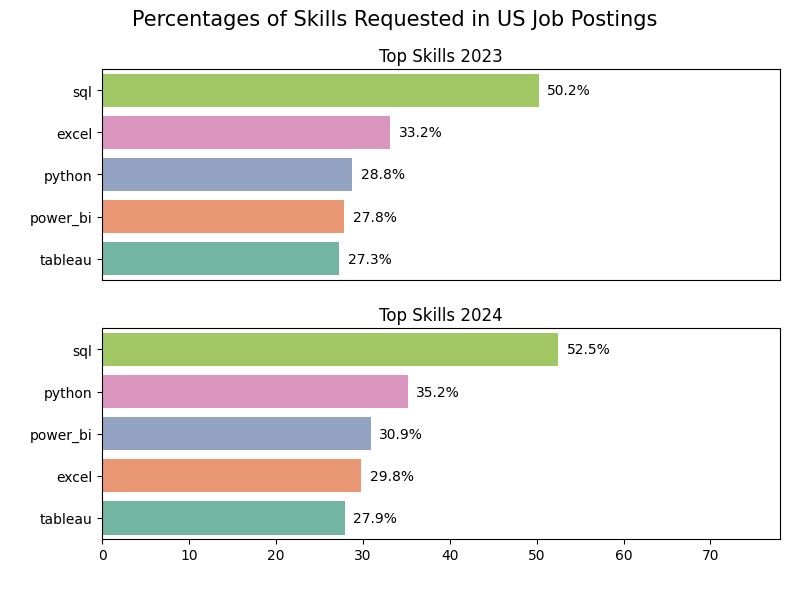

In [12]:
# Select data
df_DA_years = [df_DA_2023_exploded_count , df_DA_2024_exploded_count]

# Set titles
titles = ["Top Skills 2023", "Top Skills 2024"]

fig , ax = plt.subplots(2 , 1 , figsize = (8,6))

palette = sns.cubehelix_palette(start = .5 , rot = -.5 , as_cmap = True)

for i , df_year in enumerate(df_DA_years):
    sns.barplot(data = df_year , x = 'skills_per', y = 'job_skills', hue = 'skills_count', ax = ax[i] , palette = "Set2")
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(" ")
    ax[i].set_ylabel(" ")
    ax[i].get_legend().remove()
    ax[i].set_xlim(0,78)

    if i != len(df_DA_years) - 1:
        ax[i].set_xticks([])

    for n, v in enumerate(df_year['skills_per']):
        ax[i].text(v + 1, n, f'{v:.1f}%', va='center')
  
fig.suptitle('Percentages of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) 
plt.show()